In [ ]:
# https://www.youtube.com/watch?v=ZMudJXhsUpY&list=PLQY2H8rRoyvzDbLUZkbudP-MFQZwNmU4S&index=6

# Instalación de librerías e imports

In [1]:
import numpy as np
from google.colab import drive
import re

from gensim.models import KeyedVectors

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout, Dense
from tensorflow.keras.layers import Input, Concatenate, Dot, RepeatVector, TimeDistributed, Multiply
from tensorflow.keras.layers import Bidirectional, LSTM, Activation, Reshape, Lambda, Dropout
from tensorflow.keras.utils import plot_model, to_categorical, pad_sequences
import tensorflow.keras.callbacks as callbacks


In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Preparación de datasets

## División de txt en arreglo de párrafos

In [3]:
filepath= '/content/drive/My Drive/Dr. Jekyll and Mr. Hyde.txt'
#filepath= '/content/drive/My Drive/biblia.txt'

with open(filepath, 'r') as file:
    text = file.read()

# Eliminar num. versiculos de biblia
#text = re.sub(r'\[[^\]]*\] ', '', text)

parrafos = text.lower().split('\n\n') # Dividir el contenido en párrafos
#parrafos = text.lower().split('.')  # Dividir en oraciones

# Eliminamos enters y espacios en blanco.
dataset = [parrafo.strip().replace('\n', ' ') for parrafo in parrafos if parrafo !=""]

Se decidió dividir el texto en párrafos por lo común que resultaba las abreviaturas "Mr.", "Ms.", "St." en la literatura anglosajona.

In [4]:
corpus_size = len(dataset)
corpus_size

349

In [5]:
print(dataset[5])

mr. enfield and the lawyer were on the other side of the by-street; but when they came abreast of the entry, the former lifted up his cane and pointed.


In [6]:
from sklearn.model_selection import train_test_split
trainset, testset, _, _= train_test_split(dataset, range(corpus_size), test_size=0.2, random_state=42, shuffle=True)

trainset[0]

'“sir,” said the butler, turning to a sort of mottled pallor, “that thing was not my master, and there’s the truth. my master”—here he looked round him and began to whisper—“is a tall, fine build of a man, and this was more of a dwarf.” utterson attempted to protest. “o, sir,” cried poole, “do you think i do not know my master after twenty years? do you think i do not know where his head comes to in the cabinet door, where i saw him every morning of my life? no, sir, that thing in the mask was never dr. jekyll—god knows what it was, but it was never dr. jekyll; and it is the belief of my heart that there was murder done.”'

## Tokenizacion de textos

In [7]:
from keras.preprocessing.text import Tokenizer

token=Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ', char_level=False, oov_token="UNK", document_count=0)
token.fit_on_texts(trainset)

dictionary = token.index_word
vocab_size=len(dictionary)+1

In [8]:
def genSequences(token, text_set, max_len=500):
  x_sequences = []
  y_sequences = []

  tokenized = token.texts_to_sequences(text_set)  # Tokenizo los textos

  # Armo secuencias de largo max_len o menor
  for text in tokenized:
    for i in range(1, len(text)):
      x_sequences.append(text[:i])  # Arreglos de entrada
      y_sequences.append(text[i])   # Arreglos de salida

  x_sequences = pad_sequences(x_sequences, maxlen=max_len, padding='pre', truncating='pre')
  y_sequences = to_categorical(y_sequences, num_classes=len(token.index_word)+1)

  return x_sequences, y_sequences

In [9]:
max_len=500

x_train, y_train = genSequences(token, trainset, max_len=max_len)
x_test, y_test = genSequences(token, testset, max_len=max_len)

In [10]:
x_train[78][-200:]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
        651,    9,   24,    2,  282, 1437,    5,    6,  434,    4, 1438,
        911,  327,  166,    8,   31,   14,  200,    3,  652,    2,  653,
         14, 1439,   11,  119,  516,   32,    3,  1

# Carga de embeddings (TP viejo)

Justificar por qué elegimos FastText o pasar a Word2Vect


https://radimrehurek.com/gensim/auto_examples/tutorials/run_fasttext.html#sphx-glr-auto-examples-tutorials-run-fasttext-py

In [11]:
import codecs

embed_path='/content/drive/My Drive/wiki-news-300d-1M.vec'
#embed_path='/content/drive/My Drive/cc.es.300.vec'


embedding_dim=300               # Dato de FastText
embedding_matrix=np.zeros([vocab_size,embedding_dim])

#carga de embeddings externos
f = codecs.open(embed_path, encoding='utf-8')

for line in f:
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')

    # Armamos la matriz de embeddings en base a nuestro vocab
    if word in token.index_word.values():
      idx = next((idx for idx, dict_word in token.index_word.items() if dict_word == word), None)
      if idx != None:
        embedding_matrix[idx,:] = coefs

f.close()

In [12]:
print("Tamaño vocabulario: ", vocab_size)
print("Dim matriz de embeddings: ", embedding_matrix.shape)

Tamaño vocabulario:  3479
Dim matriz de embeddings:  (3479, 300)


# Modelo

## Arquitectura

In [13]:
def softMaxOverTime(x):
    return tf.keras.activations.softmax(x,axis=1)

TODO: Justificar las diferentes etapas de la arquitectura

In [14]:
LSTM_dim=100

input_layer = Input(shape=(max_len,))

embedding_layer=Embedding(input_dim=vocab_size, output_dim=embedding_dim,
                          weights=[embedding_matrix], input_length=max_len,
                          trainable=False)(input_layer) # Embeddings pre entrenados

# Por que merge mode = sum?
lstm_out=Bidirectional(LSTM(LSTM_dim, return_sequences=True, activation="tanh"), merge_mode="sum")(embedding_layer)
ulog_attention=Dense(1,activation="linear")(lstm_out)

attention=Activation(softMaxOverTime)(ulog_attention)
repeated_attention=TimeDistributed(RepeatVector(LSTM_dim))(attention)
repeated_attention=Reshape([max_len,LSTM_dim])(repeated_attention)

weighted_embeddings=Multiply()([repeated_attention,lstm_out])
embedding_sum = Lambda(lambda x: tf.keras.backend.sum(x, axis=1))(weighted_embeddings)

dense0=Dense(vocab_size//64, activation='relu')(embedding_sum)
dense1=Dense(vocab_size//16, activation='relu')(dense0)
dense2=Dense(vocab_size//4, activation='relu')(dense1)
dense3=Dense(vocab_size, activation='softmax')(dense2)

model=Model(input_layer , dense3)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 500)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 500, 300)             1043700   ['input_1[0][0]']             
                                                                                                  
 bidirectional (Bidirection  (None, 500, 100)             320800    ['embedding[0][0]']           
 al)                                                                                              
                                                                                                  
 dense (Dense)               (None, 500, 1)               101       ['bidirectional[0][0]']   

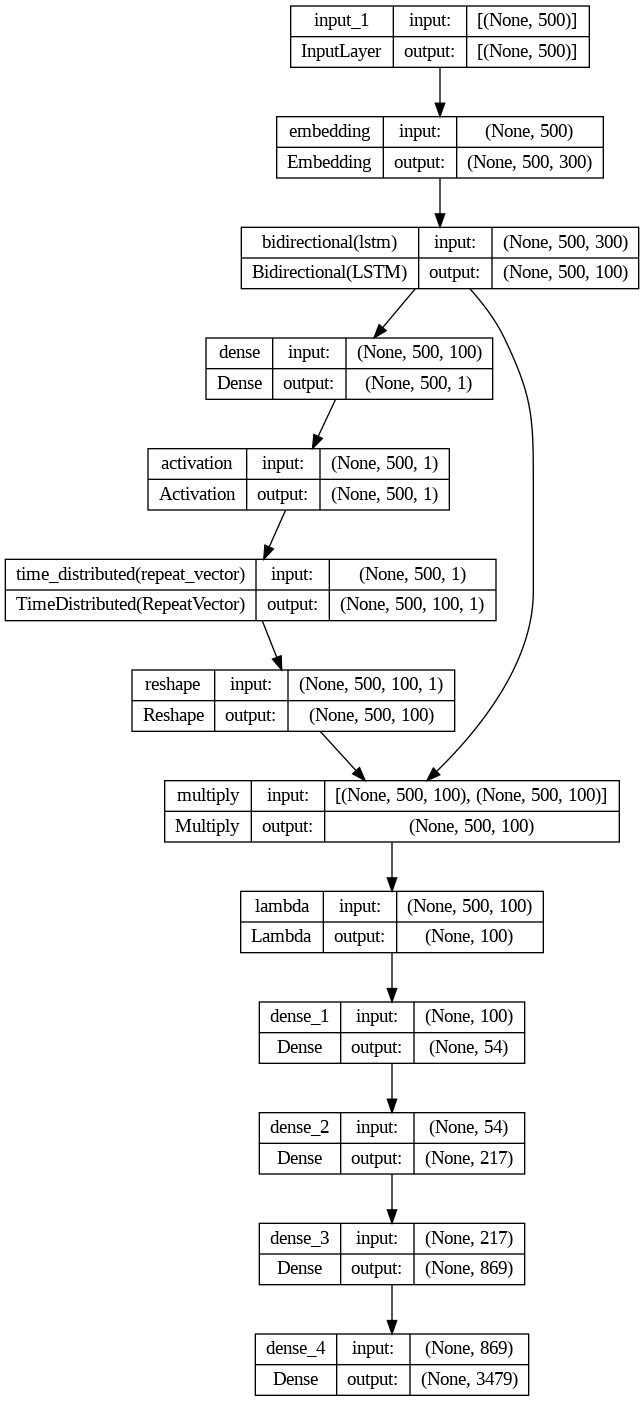

In [15]:
plot_model(model, "LM.png", show_shapes=True)

In [16]:
adam = tf.keras.optimizers.Adam(learning_rate=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
adam = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

## Entrenamiento

In [22]:
BATCH_SIZE = 32
check_cb = callbacks.ModelCheckpoint(filepath="Jeckyll.hdf5",
                                         verbose = 0, save_best_only = True)

early_cb = callbacks.EarlyStopping(monitor="accuracy", min_delta=1e-3, patience=10,
                                   start_from_epoch=10)

In [23]:
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=50,
                    callbacks=[check_cb, early_cb])

Epoch 1/50
486/486 [==============================] - 26s 53ms/step - loss: 2.3000 - accuracy: 0.3871 - val_loss: 12.9932 - val_accuracy: 0.0789
Epoch 2/50
486/486 [==============================] - 25s 50ms/step - loss: 2.1044 - accuracy: 0.4287 - val_loss: 13.4672 - val_accuracy: 0.0718
Epoch 3/50
486/486 [==============================] - 24s 50ms/step - loss: 1.9400 - accuracy: 0.4682 - val_loss: 14.6325 - val_accuracy: 0.0796
Epoch 4/50
486/486 [==============================] - 24s 50ms/step - loss: 1.7871 - accuracy: 0.4937 - val_loss: 15.1541 - val_accuracy: 0.0759
Epoch 5/50
486/486 [==============================] - 26s 53ms/step - loss: 1.6756 - accuracy: 0.5192 - val_loss: 15.6446 - val_accuracy: 0.0679
Epoch 6/50
486/486 [==============================] - 26s 53ms/step - loss: 1.5564 - accuracy: 0.5478 - val_loss: 16.5657 - val_accuracy: 0.0729
Epoch 7/50
486/486 [==============================] - 26s 53ms/step - loss: 1.4301 - accuracy: 0.5803 - val_loss: 17.0393 - val_ac

## Carga de pesos ya entrenados

In [ ]:
# Loads the weights
model.load_weights("Jeckyll.hdf5")

## Testeo

In [24]:
test_loss, test_acc = model.evaluate(x_test,  y_test)
print(test_acc)

198/198 [==============================] - 4s 21ms/step - loss: 32.8262 - accuracy: 0.0620
0.06200569495558739


# Prediccion

In [2]:
def idx2word(token, pred_idx):
  for idx, word in token.index_word.items():
      if idx == pred_idx:
        return word

  return None

## Greedy Search + ArgMax

In [78]:
def greedy(seed_phrase, token, model, pred_len=25, max_len=500):
  seed_text = seed_phrase
  pred_arr = ""
  for _ in range(pred_len):
    tokenized = token.texts_to_sequences([seed_text])[0]
    tokenized = pad_sequences([tokenized], maxlen=max_len)
    pred_idx = np.argmax(model.predict(tokenized, verbose=0)[0])

    word = idx2word(token, pred_idx)
    if word != None:
      seed_text += " " + word
      pred_arr += " " + word

  return pred_arr

In [74]:
seed= "Jekyll said"
prediction = greedy(seed, token, model, pred_len=25)
print(seed, prediction)

Jekyll said  to the servant now in silence and then with mr utterson had a feverish long fender this hall and that the could he drew the


In [77]:
prediction = ""

while(True):
  seed=input("Seed:")
  if seed != "":
    prediction = greedy(seed, token, model)
  else:
    prediction = greedy(prediction, token, model)
  print(prediction)

Seed:jekyll
 ” said the lawyer “i once spoke with him ”
Seed:
 said he “i “i have a god figure that it
Seed:
 was always now ten i would it not mr i
Seed:
 bind my master and even my master’s hand before i
Seed:
 could ask you to help you to ask you to
Seed:
 ask you to ask you to ask you to ask
Seed:
 you to ask you to ask you to ask you


KeyboardInterrupt: ignored

## Greedy Search + Temperatura

In [ ]:
import random

def greedyTemp(seed_phrase, token, model, temp=1, pred_len=25, max_len=500):
  seed_text = seed_phrase
  pred_arr = ""
  for _ in range(pred_len):

    # Tokenizamos y paddeamos
    tokenized = token.texts_to_sequences([seed_text])[0]
    tokenized = pad_sequences([tokenized], maxlen=max_len)

    # Predecimos considerando temperatura y elegimos de forma semialeatoria
    probs = (model.predict(tokenized, verbose=0)[0])**(1/temp)
    pred_idx = random.choices(range(len(probs)), weights=probs, k=1)

    word = idx2word(token, pred_idx)
    if word != None:
      seed_text += " " + word
      pred_arr += " " + word

  return pred_arr

## Stochastic Beam Search

In [ ]:
import numpy as np

def stochastic_beam_search(modelo, texto_inicial, n_beam=3, max_pasos=20, temperatura=1.0):
    secuencias = [{'texto': texto_inicial, 'probabilidad': 1.0}]

    for paso in range(max_pasos):
        nuevas_secuencias = []

        for secuencia in secuencias:
            texto_actual = secuencia['texto']
            probabilidad_acumulada = secuencia['probabilidad']

            probabilidades = predecir_probabilidades(texto_actual)

            # Aplica temperatura para controlar la aleatoriedad
            probabilidades_ajustadas = {palabra: p ** (1.0 / temperatura) for palabra, p in probabilidades.items()}

            palabras_candidatas = list(probabilidades_ajustadas.keys())
            probabilidades_candidatas = list(probabilidades_ajustadas.values())

            palabra_elegida = np.random.choice(palabras_candidatas, p=probabilidades_candidatas)

            probabilidad_elegida = probabilidades[palabra_elegida]
            probabilidad_acumulada *= probabilidad_elegida

            nuevo_texto = texto_actual + ' ' + palabra_elegida

            nuevas_secuencias.append({'texto': nuevo_texto, 'probabilidad': probabilidad_acumulada})

        nuevas_secuencias.sort(key=lambda x: -x['probabilidad'])
        secuencias = nuevas_secuencias[:n_beam]

    mejor_secuencia = secuencias[0]
    return mejor_secuencia['texto']

# Uso de Stochastic Beam Search con temperatura
texto_generado = stochastic_beam_search(modelo_de_lenguaje, 'El', n_beam=5, max_pasos=10, temperatura=0.7)
print("Texto generado:", texto_generado)


In [ ]:
def stochasticBeam()

# Metricas de generación

## Introducción

Métricas de Calidad del Texto:

* **Perplejidad**: La perplejidad mide cuán bien un modelo de lenguaje puede predecir una secuencia de palabras en función de su entrenamiento. Cuanto más bajo sea el valor de perplejidad, mejor es la calidad del texto, ya que indica que el modelo puede predecir con precisión las palabras siguientes en la secuencia. Se utiliza en la evaluación de modelos de lenguaje para evaluar la calidad de la generación de texto

* **BLEU** (Bilingual Evaluation Understudy): es una métrica comúnmente utilizada para evaluar la calidad de la traducción automática y la generación de texto. Compara la similitud de n-gramas (secuencias de palabras) generados por el modelo con las secuencias de palabras de referencia. Cuanto más cercanos sean los n-gramas generados a las referencias, mayor será el puntaje BLEU. Muy utilizado en la evaluación automática de sistemas de traducción automática y generación de resúmenes, entre otros

* **ROUGE** (Recall-Oriented Understudy for Gisting Evaluation): se enfoca en medir la similitud entre palabras y frases del texto generado y las de referencia. Puede incluir métricas como ROUGE-1 (unigramas), ROUGE-2 (bigramas), y ROUGE-L (la longitud de la secuencia común más larga). Se utiliza en la evaluación de resúmenes automáticos y generación de texto. Cuanto más alto sea el puntaje ROUGE, mejor será la calidad del texto generado.

## Perplejidad

In [ ]:
import nltk
from nltk.lm import MLE
from nltk.util import ngrams
import math

# Texto de entrenamiento
training_text = "Este es un ejemplo de texto de entrenamiento para calcular la perplejidad."

# Tokeniza el texto de entrenamiento
tokens = nltk.word_tokenize(training_text)

# Crea un modelo de lenguaje de máxima probabilidad (MLE)
n = 3  # Orden del modelo de lenguaje (trigramas en este caso)
lm = MLE(n)
lm.fit([ngrams(tokens, n)])

# Texto de prueba
test_text = "Este es un ejemplo de texto de prueba para calcular la perplejidad."

# Tokeniza el texto de prueba
test_tokens = nltk.word_tokenize(test_text)

# Calcula la perplejidad del texto de prueba
perplexity = math.pow(2, -lm.perplexity(test_tokens))
print("Perplejidad:", perplexity)

In [ ]:
import tensorflow as tf

# Supongamos que ya tienes un modelo de lenguaje previamente entrenado en TensorFlow

# Definir una función para calcular la probabilidad de una secuencia de palabras
def calcular_probabilidad(modelo, secuencia):
    # Supongamos que `modelo` es una instancia de tu modelo de lenguaje en TensorFlow
    # `secuencia` es una lista de índices de palabras

    # Calcular la probabilidad logarítmica de la secuencia
    log_probabilidad = modelo(secuencia)

    # Calcular la perplejidad
    perplejidad = tf.exp(-log_probabilidad)

    return perplejidad

# Texto de prueba (secuencia de índices de palabras)
texto_de_prueba = [10, 20, 30, 40, 50]  # Reemplaza con tu propia secuencia

# Calcula la perplejidad
perplejidad = calcular_probabilidad(modelo_de_lenguaje, texto_de_prueba)

print("Perplejidad:", perplejidad)


## BLEU

In [1]:
import nltk
from nltk.translate.bleu_score import sentence_bleu

blue_calc = lambda ref, pred: sentence_bleu(ref, pred)

# Carga de embeddings (GPT)

Justificar por qué elegimos FastText o pasar a Word2Vect


https://radimrehurek.com/gensim/auto_examples/tutorials/run_fasttext.html#sphx-glr-auto-examples-tutorials-run-fasttext-py

In [ ]:
word_vectors = KeyedVectors.load_word2vec_format('/content/drive/My Drive/wiki-news-300d-1M.vec') #ingles
#word_vectors = KeyedVectors.load_word2vec_format('/content/drive/My Drive/cc.es.300.vec')        #español

In [ ]:
# Variables auxiliares
vocab_size = len(word_vectors.index_to_key)
embedding_dim = word_vectors.vector_size

In [ ]:
# Carga de coeficientes del embedding
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for i in range(vocab_size):
    embedding_vector = word_vectors[word_vectors.index_to_key[i]]
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_matrix.shape

(999994, 300)

Justificar por qué elegimos FastText o pasar a Word2Vect


https://radimrehurek.com/gensim/auto_examples/tutorials/run_fasttext.html#sphx-glr-auto-examples-tutorials-run-fasttext-py

In [ ]:
import codecs

embedding_dim=300               # Dato de FastText
embedding_matrix=np.zeros([vocab_size,embedding_dim])

#carga de embeddings externos
f = codecs.open('/content/drive/My Drive/wiki-news-300d-1M.vec', encoding='utf-8')

for line in f:
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')

    # Armamos la matriz de embeddings en base a nuestro vocab
    if word in token.index_word.values():
      idx = next((idx for idx, dict_word in token.index_word.items() if dict_word == word), None)
      if idx != None:
        embedding_matrix[idx,:] = coefs

f.close()

In [ ]:
print("Tamaño vocabulario: ", vocab_size)
print("Dim matriz de embeddings: ", embedding_matrix.shape)

Tamaño vocabulario:  3479
Dim matriz de embeddings:  (3479, 300)
